In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# install library
! pip install -q kaggle

In [3]:
# import files class to upload files to colab
from google.colab import files

In [4]:
# upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"georgiostsarouchas","key":"b5c59161427c6ebbaa08ab781b2673a4"}'}

In [5]:
# Make directory named kaggle and copy kaggle.json file there.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Add, DepthwiseConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50,VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import EarlyStopping,LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
plt.rcParams['font.size'] = 16
import os
import cv2
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from PIL import Image

In [7]:
! kaggle datasets download -d andrewmvd/medical-mnist

 86% 73.0M/84.8M [00:00<00:00, 107MB/s] 
100% 84.8M/84.8M [00:00<00:00, 110MB/s]


In [8]:
! mkdir medical_mnist
! unzip medical-mnist.zip -d medical_mnist

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: medical_mnist/HeadCT/005000.jpeg  
  inflating: medical_mnist/HeadCT/005001.jpeg  
  inflating: medical_mnist/HeadCT/005002.jpeg  
  inflating: medical_mnist/HeadCT/005003.jpeg  
  inflating: medical_mnist/HeadCT/005004.jpeg  
  inflating: medical_mnist/HeadCT/005005.jpeg  
  inflating: medical_mnist/HeadCT/005006.jpeg  
  inflating: medical_mnist/HeadCT/005007.jpeg  
  inflating: medical_mnist/HeadCT/005008.jpeg  
  inflating: medical_mnist/HeadCT/005009.jpeg  
  inflating: medical_mnist/HeadCT/005010.jpeg  
  inflating: medical_mnist/HeadCT/005011.jpeg  
  inflating: medical_mnist/HeadCT/005012.jpeg  
  inflating: medical_mnist/HeadCT/005013.jpeg  
  inflating: medical_mnist/HeadCT/005014.jpeg  
  inflating: medical_mnist/HeadCT/005015.jpeg  
  inflating: medical_mnist/HeadCT/005016.jpeg  
  inflating: medical_mnist/HeadCT/005017.jpeg  
  inflating: medical_mnist/HeadCT/005018.jpeg  
  inflating: medical_mnist/HeadCT

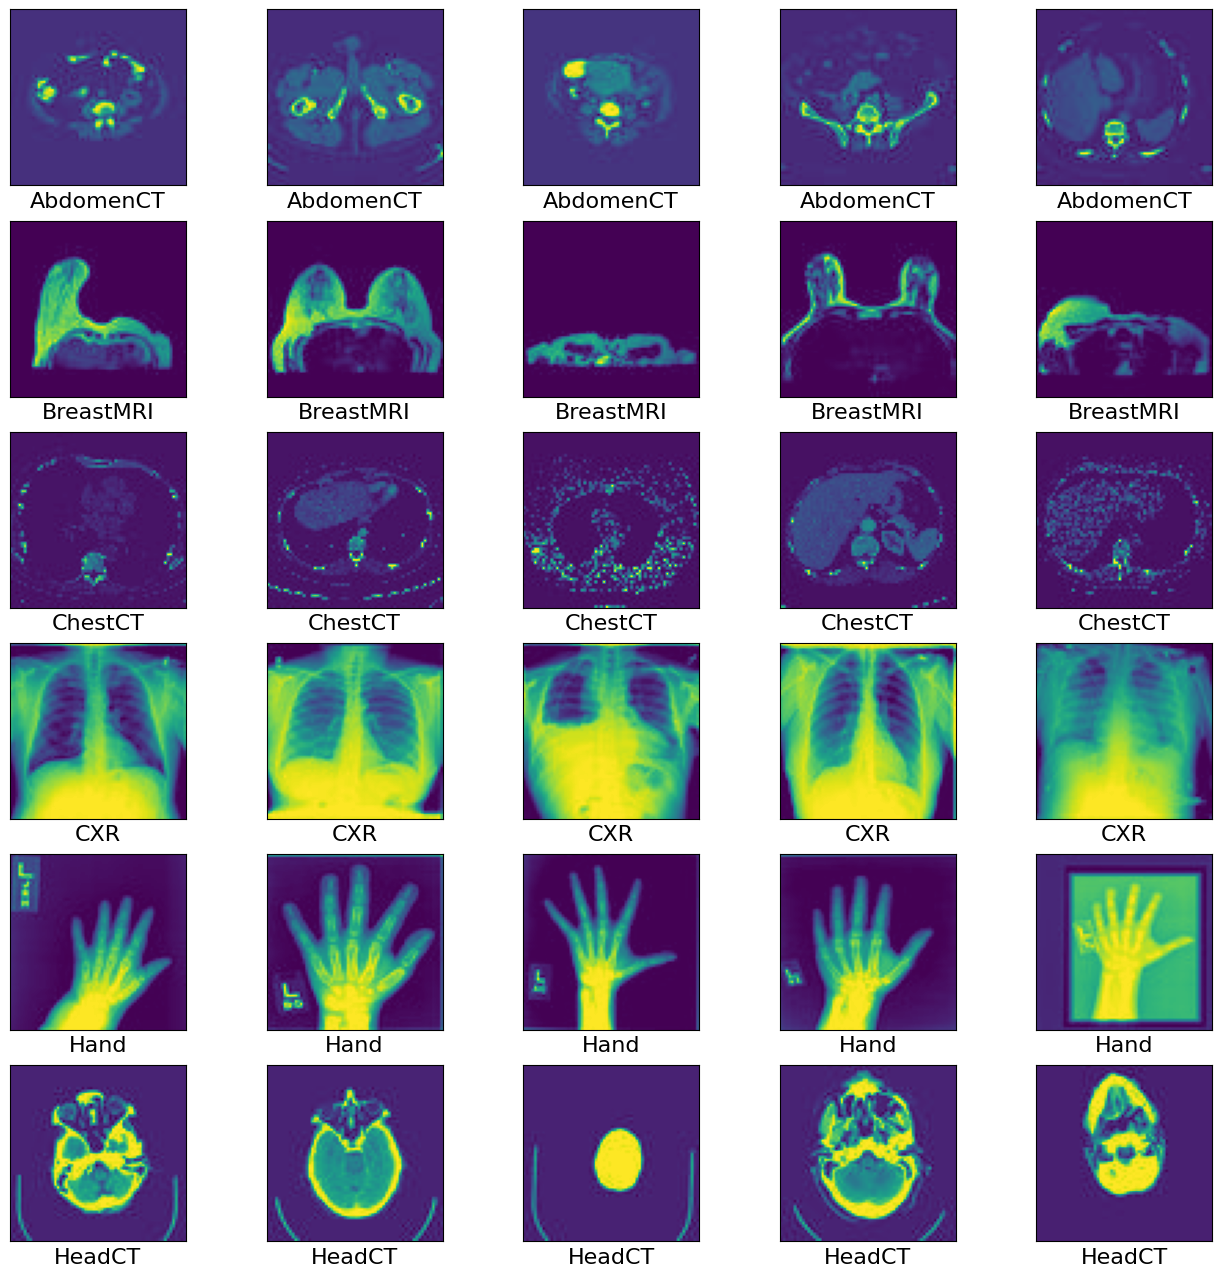

In [9]:
#plot few images
AbdomenCT_dir = 'medical_mnist/AbdomenCT/'
BreastMRI_dir = 'medical_mnist/BreastMRI/'
ChestCT_dir = 'medical_mnist/ChestCT/'
CXR_dir = 'medical_mnist/CXR/'
Hand_dir = 'medical_mnist/Hand/'
HeadCT_dir = 'medical_mnist/HeadCT/'
classes = ['AbdomenCT', 'BreastMRI','ChestCT','CXR','Hand','HeadCT']
AbdomenCT_img = [im for im in os.listdir('medical_mnist/AbdomenCT')
              if any(im.endswith(ext) for ext in ['jpg','png','jpeg'])]
BreastMRI_img = [im for im in os.listdir('medical_mnist/BreastMRI')
              if any(im.endswith(ext) for ext in ['jpg','png','jpeg'])]
ChestCT_img = [im for im in os.listdir('medical_mnist/ChestCT')
              if any(im.endswith(ext) for ext in ['jpg','png','jpeg'])]
CXR_img = [im for im in os.listdir('medical_mnist/CXR')
              if any(im.endswith(ext) for ext in ['jpg','png','jpeg'])]
Hand_img = [im for im in os.listdir('medical_mnist/Hand')
              if any(im.endswith(ext) for ext in ['jpg','png','jpeg'])]
HeadCT_img = [im for im in os.listdir('medical_mnist/HeadCT')
              if any(im.endswith(ext) for ext in ['jpg','png','jpeg'])]
plt.figure(figsize=(16, 16))
for i in range(30):
  plt.subplot(6,5,i+1)
  plt.xticks([])
  plt.yticks([])
  if i < 5:
    path = AbdomenCT_dir + AbdomenCT_img[i]
    plt.xlabel(classes[0])
  elif 5 <= i < 10:
    path = BreastMRI_dir + BreastMRI_img[i]
    plt.xlabel(classes[1])
  elif 10 <=i < 15:
    path = ChestCT_dir + ChestCT_img[i]
    plt.xlabel(classes[2])
  elif 15 <=i < 20:
    path = CXR_dir + CXR_img[i]
    plt.xlabel(classes[3])
  elif 20 <=i < 25:
    path = Hand_dir + Hand_img[i]
    plt.xlabel(classes[4])
  else:
    path = HeadCT_dir + HeadCT_img[i]
    plt.xlabel(classes[5])
  img = plt.imread(path)
  plt.imshow(img)

Binary Classification

In [10]:
# convert images to 32x32x3 shape
images = []
labels = []
shape = 32, 32

for image in Hand_img:
    temp_img = cv2.imread(Hand_dir + image)
    temp_img = cv2.resize(temp_img, shape)
    images.append(temp_img.reshape(-1,))
    labels.append(0)

for image in HeadCT_img:
    temp_img = cv2.imread(HeadCT_dir + image)
    temp_img = cv2.resize(temp_img, shape)
    images.append(temp_img.reshape(-1,))
    labels.append(1)

In [11]:
#normalize images
images_binary = np.array(images)
images_binary = images_binary.astype('float32')/255.0

In [12]:
#split dataset
from sklearn.model_selection import train_test_split
x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(images_binary,labels,test_size=0.2, random_state=0)
print(x_train_bin.shape, x_test_bin.shape)

(16000, 3072) (4000, 3072)


In [13]:
y_train_bin = np.asarray(y_train_bin)
y_test_bin = np.asarray(y_test_bin)

In [14]:
print(x_train_bin.shape, x_test_bin.shape)

(16000, 3072) (4000, 3072)


Custom Network

In [15]:
def sigmoid(z):
    a = 1./(1+np.exp(-z))
    return a

In [16]:
def relu(z):
    a = np.maximum(z,0)
    return a

In [17]:
# check relu function
assert relu(-1) == 0
assert relu(2) == 2

In [18]:
def init_params(n_in, n_out):

    # set random seed to 0
    # Hint, check np.random.uniform
    np.random.seed(0)
    # init random params and multiply it with 0.1
    w = np.random.randn(n_in, n_out)*0.01
    b = np.random.randn(n_out)*0.01
    return w, b

In [19]:
# check init params
w, b  = init_params(2,3)
print(np.round(w,4) == np.array([[ 0.0176,  0.004 ,  0.0098],[ 0.0224,  0.0187, -0.0098]]))
print(np.round(b,4) == np.array([0.0095, -0.0015, -0.001]))

[[ True  True  True]
 [ True  True  True]]
[ True  True  True]


In [20]:
def costFunction(y, m, a):
    """
    Computes cost for linear regression.
    X : feature vector, shape (m x n+1)
    y : labels (i.e., dog or cat), shape (m, )
    w : parameters for the linear regression, shape (n+1, )
    m: data legth

    returns
    -------
    J : value of cost function.
    """

    J = -1/m * np.sum(y*np.log(a) + (1-y)*np.log(1-a))


    return J

In [21]:
#forward pass
def forward(X, w, b, activation = 'relu'):
    z = np.dot(X,w) + b
    if activation=='relu':
        a = relu(z)
    else:
        a = sigmoid(z)
    return a

In [22]:
w, b  = init_params(2,3)
forward(np.asarray([[1,2],[3,4]]), w, b, 'relu')[0].shape

(3,)

In [23]:
#relu gradient
def reluBackward(z):
    #TO DO
    z[z<=0] = 0
    z[z>0] = 1
    return z

In [24]:
#backpropagation
def backward(a, dz):
    m = len(a)
    # TO DO
    # dz is equal to A-Y for the final layer so you could use the above eq replacing
    dw = np.dot(a.T, dz) / m
    db = np.sum(dz, axis=0, keepdims=True) / m

    return dw, db

In [25]:
# update parameters for optimization
def update(w, b, dw, db):
    w = w - learning_rate*dw
    b = b - learning_rate*db
    return w, b

In [26]:
#forward pass
def dummy_neural(X, y, n_layer_1, epochs = 100):
    parameters = {}
    gradients = {}
    costs = []

    n_in = X.shape[1]
    n_out = 1

    # initialize network with 1 hidden layer (and 1 output of course).
    # Layer 1 should have 200 neurons
    w1, b1 = init_params(n_in, n_layer_1)
    w2, b2 = init_params(n_layer_1, n_out)

    parameters['w1'] = w1
    parameters['b1'] = b1
    parameters['w2'] = w2
    parameters['b2'] = b2

    for i in range(epochs):

        #forward pass
        a1 = forward(X, w1, b1, activation = 'relu')
        a2 = forward(a1, w2, b2, activation = 'sigmoid')

        #cost function
        cost = costFunction(y, len(y), a2)
        costs.append(cost)

        #backward pass
        dz2 = a2-y
        dw2, db2 = backward(a2, dz2)
        dz1 = np.dot((dz2),w2.T)*reluBackward(np.dot(X,w1) + b1)
        dw1, db1 = backward(X, dz1)

        gradients['dw1'] = dw1
        gradients['db1'] = db1
        gradients['dw2'] = dw2
        gradients['db2'] = db2

        #update weights
        w2, b2 = update(w2, b2, dw2, db2)
        w1, b1 = update(w1, b1, dw1, db1)

        parameters['w1'] = w1
        parameters['b1'] = b1
        parameters['w2'] = w2
        parameters['b2'] = b2

        if i%10==0:

            a1t = forward(x_test_bin, w1, b1, activation = 'relu')
            a2t = forward(a1t, w2, b2, activation = 'sigmoid')

            print("epoch {} with cost {}".format(i,cost))
            print("train:", np.mean(np.round(a2)==y))
            print("test:", np.mean(np.round(a2t.reshape(-1))==y_test_bin))

    return parameters, a2, costs, gradients

In [27]:
learning_rate = 0.01
a = dummy_neural(x_train_bin, y_train_bin.reshape(-1,1), 200, 100)

epoch 0 with cost 0.6945979642018241
train: 0.4483125
test: 0.47175
epoch 10 with cost 0.688543663942837
train: 0.78
test: 0.79975
epoch 20 with cost 0.6831601242361464
train: 0.819
test: 0.84
epoch 30 with cost 0.6782114867091832
train: 0.8700625
test: 0.885
epoch 40 with cost 0.6737032753550866
train: 0.9026875
test: 0.914
epoch 50 with cost 0.6697053198546946
train: 0.9199375
test: 0.9225
epoch 60 with cost 0.6660212449654014
train: 0.9273125
test: 0.92675
epoch 70 with cost 0.6624902407257448
train: 0.927625
test: 0.92475
epoch 80 with cost 0.6590198434502754
train: 0.9255
test: 0.922
epoch 90 with cost 0.6555630283626102
train: 0.92175
test: 0.91775


In [31]:
# check the test accuracy
a1t = forward(x_test_bin, a[0]['w1'], a[0]['b1'], activation = 'relu')
a2t = forward(a1t, a[0]['w2'], a[0]['b2'], activation = 'sigmoid')
print(np.mean(np.round(a2t.reshape(-1))==y_test_bin))
assert np.mean(np.round(a2t.reshape(-1))==y_test_bin) == 0.91375

0.91375


Neural Network Binary

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [42]:
model = Sequential()
model.add(Dense(200, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [43]:
batch_size = 128
epochs = 50

model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model.fit(x_train_bin, y_train_bin, batch_size=batch_size, epochs=epochs,
          validation_data=(x_test_bin, y_test_bin))

Epoch 1/50
125/125 [==============================] - 1s 5ms/step - loss: 0.2402 - accuracy: 0.9408 - val_loss: 0.1548 - val_accuracy: 0.9630
Epoch 2/50
125/125 [==============================] - 0s 3ms/step - loss: 0.1357 - accuracy: 0.9686 - val_loss: 0.1225 - val_accuracy: 0.9695
Epoch 3/50
125/125 [==============================] - 1s 4ms/step - loss: 0.1137 - accuracy: 0.9731 - val_loss: 0.1067 - val_accuracy: 0.9725
Epoch 4/50
125/125 [==============================] - 0s 3ms/step - loss: 0.1011 - accuracy: 0.9756 - val_loss: 0.0962 - val_accuracy: 0.9743
Epoch 5/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0922 - accuracy: 0.9768 - val_loss: 0.0875 - val_accuracy: 0.9765
Epoch 6/50
125/125 [==============================] - 0s 4ms/step - loss: 0.0856 - accuracy: 0.9781 - val_loss: 0.0815 - val_accuracy: 0.9778
Epoch 7/50
125/125 [==============================] - 1s 4ms/step - loss: 0.0800 - accuracy: 0.9799 - val_loss: 0.0774 - val_accuracy: 0.9780
Epoch 

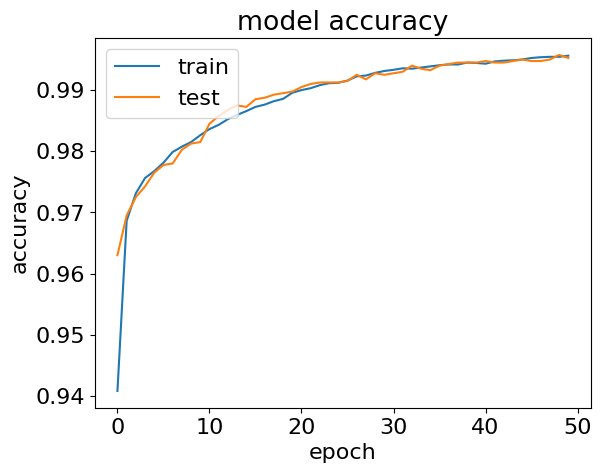

In [44]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

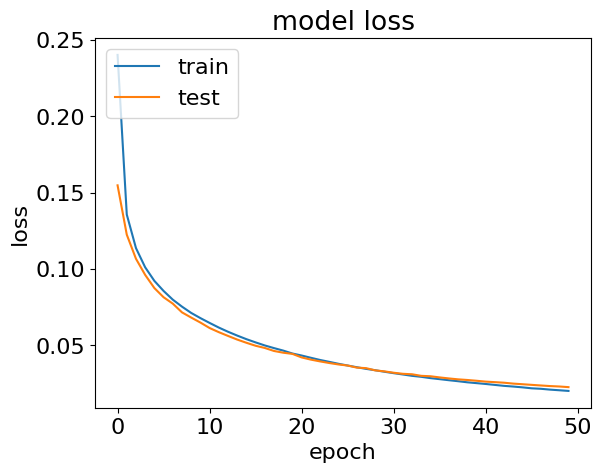

In [45]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()